In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from pathlib import Path
import pandas as pd

np.random.seed(42)

## Data Loading, preprocessing and visualization

In [2]:
data_path = Path("data/S2_A1_E1.mat")

In [3]:
data = loadmat(data_path)

In [4]:
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
stimulus
emg
glove
restimulus
repetition
rerepetition


In [5]:
emg_rectified = data["emg"].copy()

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


In [6]:
# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 12
How many repetitions are there? 10


In [7]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

In [8]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 


Text(0.5, 0.98, 'Envelopes of the EMG signal')

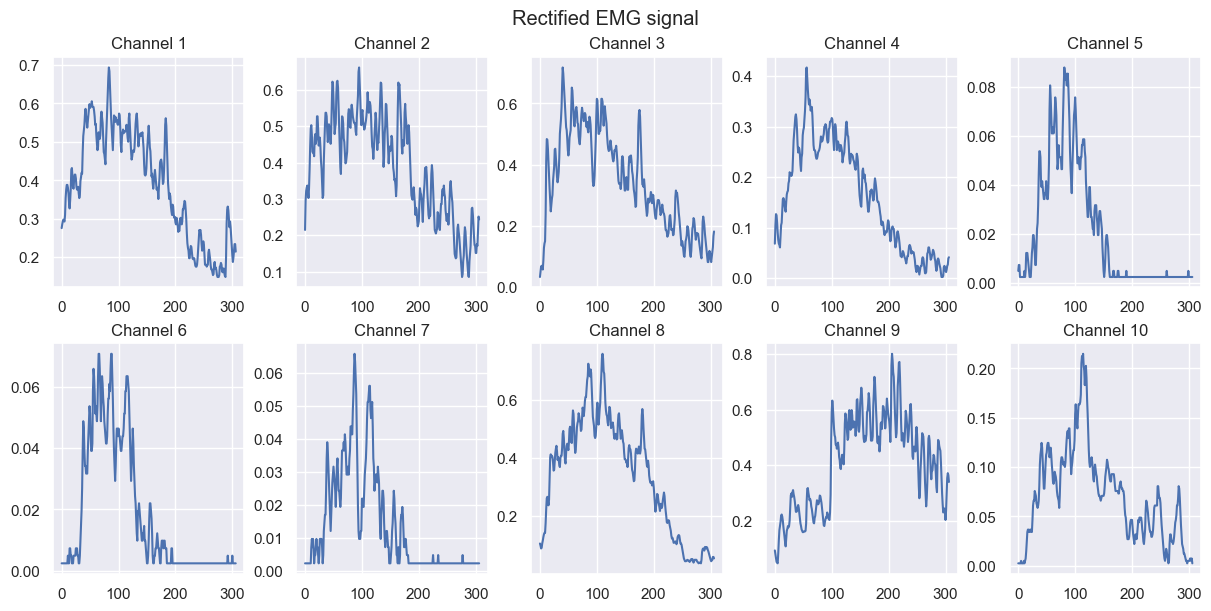

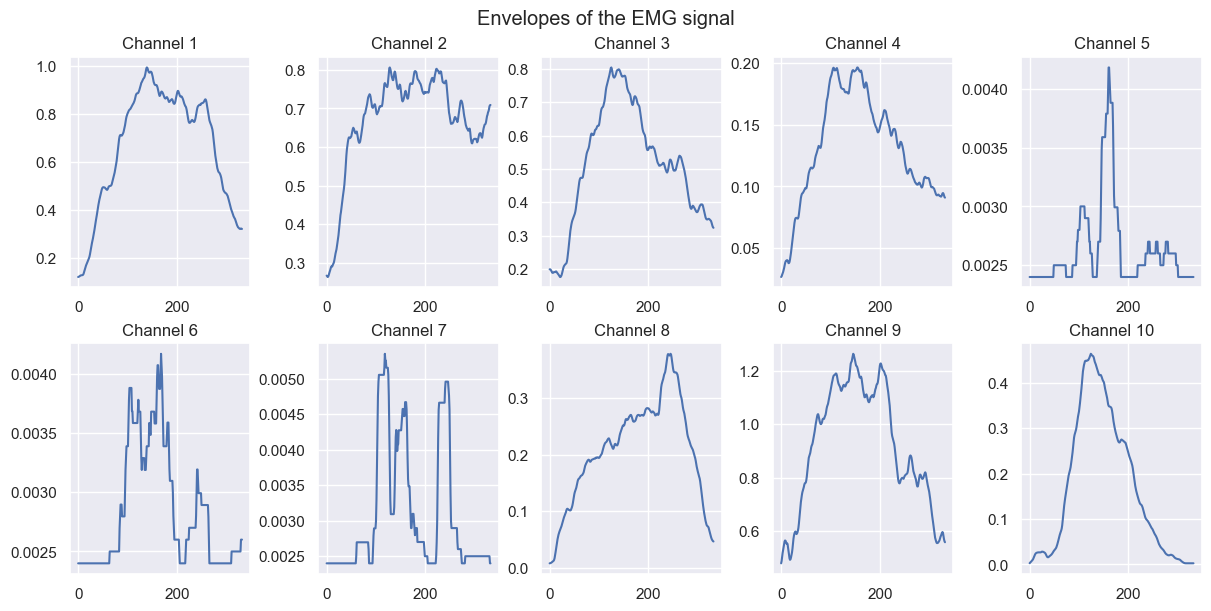

In [24]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

#10 EMG channels
number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[1][4][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

Text(0.5, 0.98, 'Envelopes of the EMG signal')

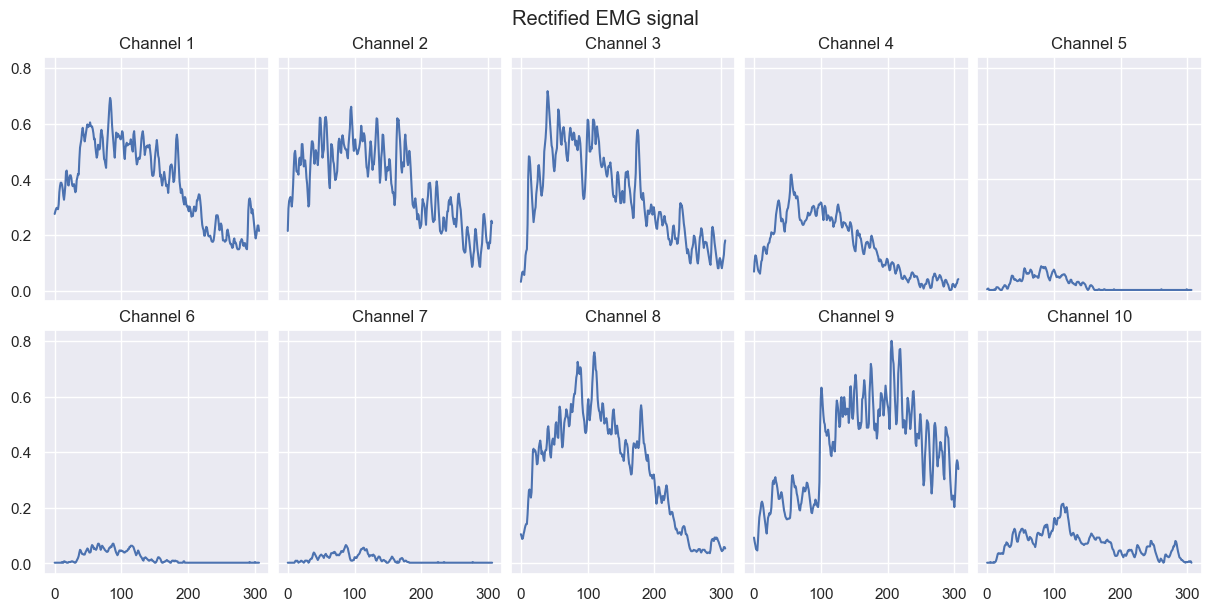

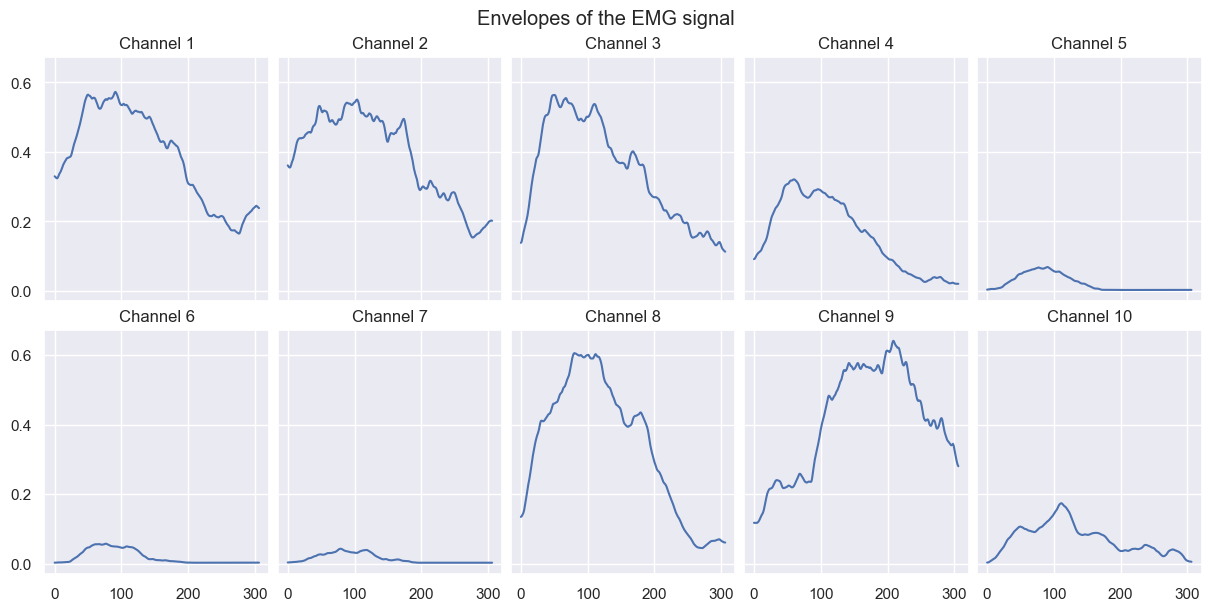

In [43]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

Visualing the EMG envelopes accross all trials for a given action

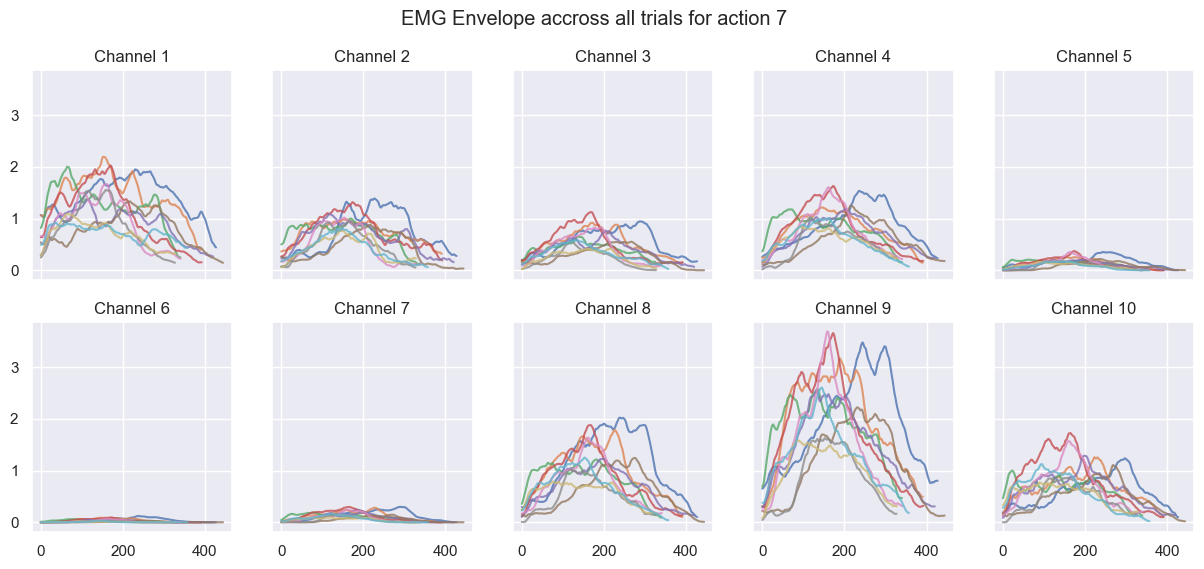

In [86]:
action_idx = 6   # e.g. eighth action
num_trials = len(emg_windows[action_idx])
num_channels = emg_windows[action_idx][0].shape[-1]

fig, ax = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
ax = ax.ravel()

for ch in range(num_channels):
    for trial in range(num_trials):
        ax[ch].plot(emg_envelopes[action_idx][trial][:, ch], alpha=0.8)
    ax[ch].set_title(f"Channel {ch+1}")

plt.suptitle(f"EMG Envelope accross all trials for action {action_idx + 1}")
plt.show()


In [11]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

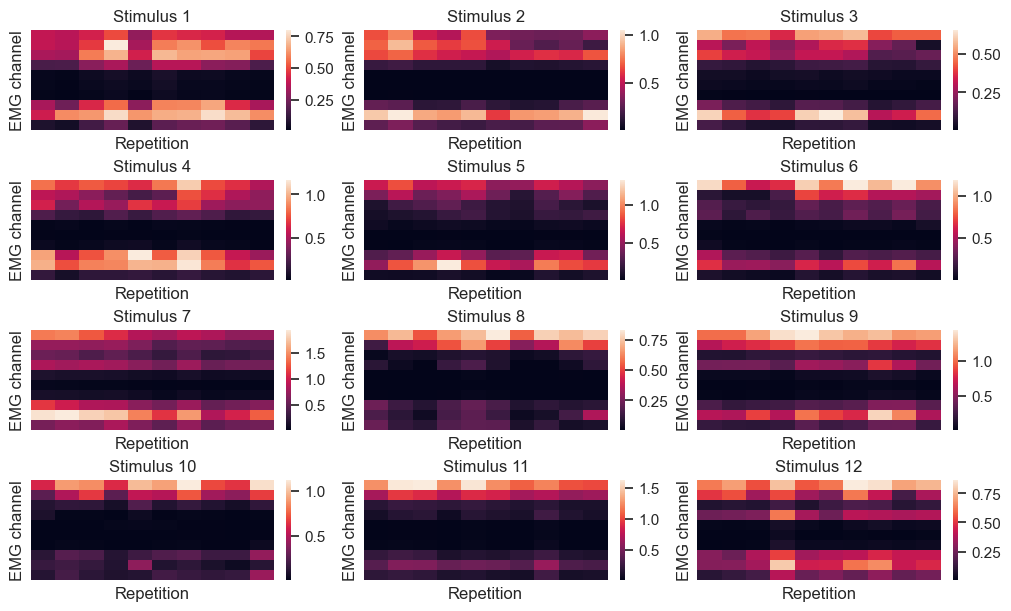

In [12]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

In [13]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

## Feature extraction

In [14]:
import numpy as np

# Si emg_envelopes est une liste de listes : [[array(...), ...], [...], ...]
all_segments = [seg for row in emg_envelopes for seg in row]

emg_stacked = np.vstack(all_segments)
print(emg_stacked.shape)   # (N_total, 10) normalement



(41791, 10)


In [15]:
emg_rectified

array([[0.0269, 0.1001, 0.0024, ..., 0.0024, 0.0024, 0.0024],
       [0.0269, 0.0757, 0.0024, ..., 0.0024, 0.0024, 0.0024],
       [0.0317, 0.0586, 0.0024, ..., 0.0024, 0.0024, 0.0024],
       ...,
       [0.1978, 0.3101, 0.0366, ..., 0.0049, 0.0024, 0.0024],
       [0.1978, 0.2832, 0.0317, ..., 0.0024, 0.0024, 0.0024],
       [0.1953, 0.3052, 0.0317, ..., 0.0049, 0.0024, 0.0024]],
      shape=(100686, 10))

In [16]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
# Sum of absolute differences between consecutive samples
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

features = [mav, std, maxav, rms, wl, ssc]

dataset, labels = build_dataset_from_ninapro(
    emg=emg_rectified,
    stimulus=stimulus,
    repetition=repetition,
    features=features  # or [mav, std] if you're starting simple
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")


dataset dimension: (120, 60)
labels dimension: (120,)


In [82]:
feature_names = ["Mean absolute value", "Standard Deviation", "Maximum absolute value", "Root mean square", "Waveform length", "Sum of absolute differences"]

In [84]:
n_trials   = dataset.shape[0]
n_features = len(feature_names)
n_channels = emg_rectified.shape[1]

# (trials, features, channels)
data_reshaped = dataset.reshape(n_trials, n_features, n_channels)

labels_int    = labels.astype(int)
unique_labels = np.unique(labels_int)
n_movements   = len(unique_labels)

# means[feature, channel, movement]
means = np.zeros((n_features, n_channels, n_movements))

for fi in range(n_features):
    for mi, mov in enumerate(unique_labels):
        mask = labels_int == mov                  # trials of this movement
        # average over trials -> one value per channel
        means[fi, :, mi] = data_reshaped[mask, fi, :].mean(axis=0)


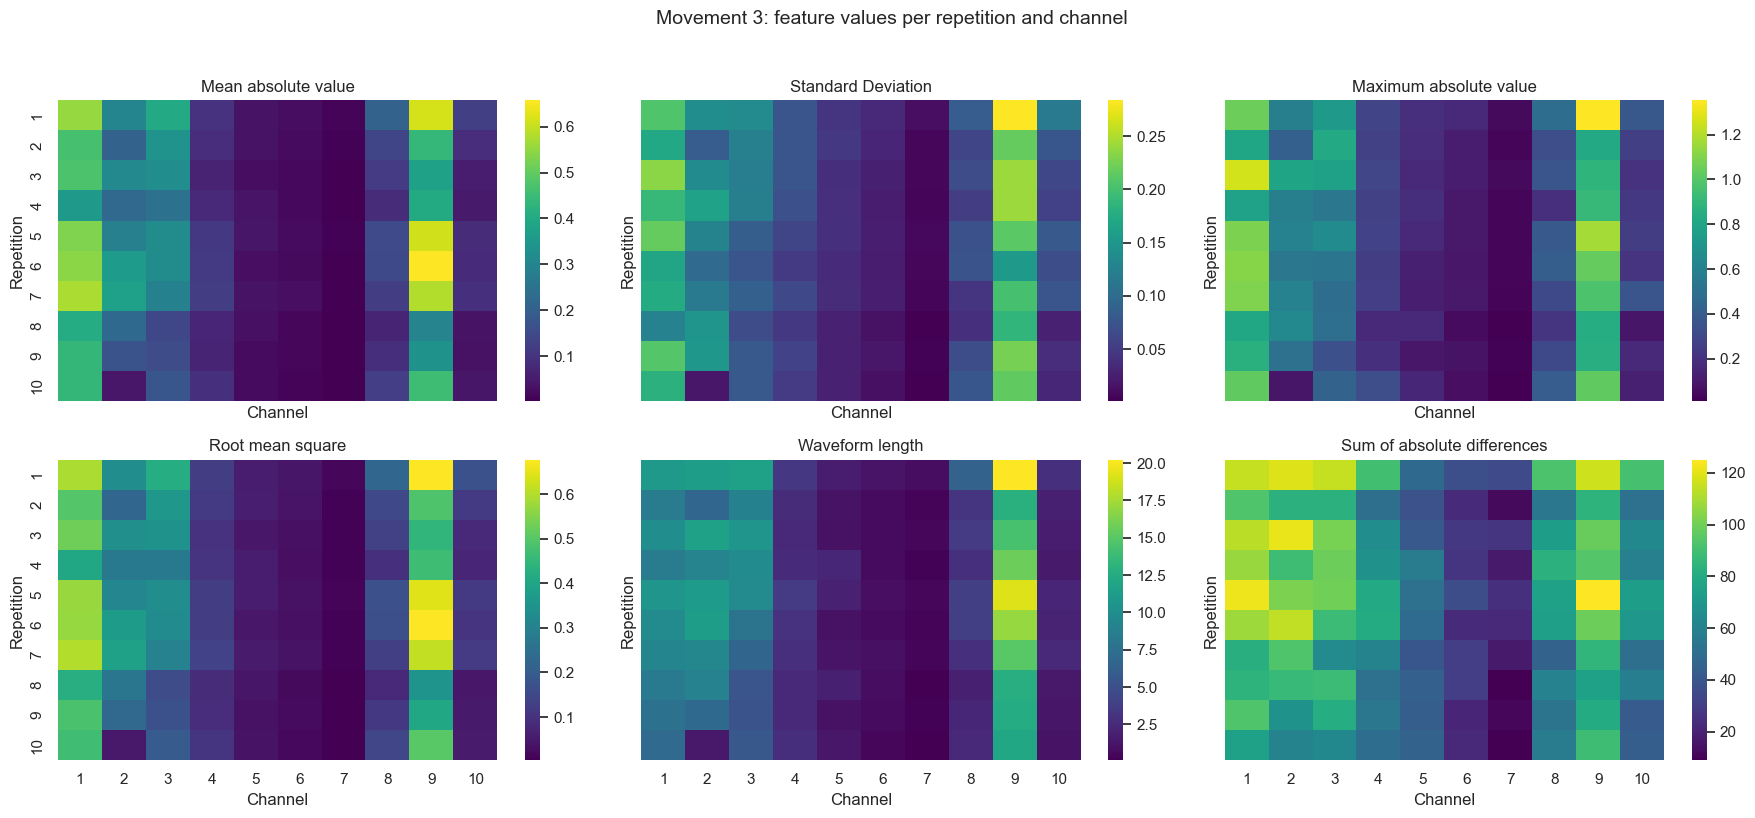

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----- choose movement (label) -----
movement_to_plot = 3          # <-- set this to the movement you want

labels_int   = labels.astype(int)
n_trials     = dataset.shape[0]
n_features   = len(feature_names)
n_channels   = emg_rectified.shape[1]

# reshape: (trials, features, channels)
data_reshaped = dataset.reshape(n_trials, n_features, n_channels)

# trials (repetitions) for this movement
mask      = labels_int == movement_to_plot
reps_data = data_reshaped[mask, :, :]          # shape: (n_reps, n_features, n_channels)

n_reps = reps_data.shape[0]

# ----- 6 heatmaps: rows = reps (1..n_reps), cols = channels (1..n_channels) -----
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.ravel()

for fi, ax in enumerate(axes):
    # matrix for this feature: (reps, channels)
    mat = reps_data[:, fi, :]   # shape (n_reps, n_channels)

    sns.heatmap(
        mat,
        ax=ax,
        cmap="viridis",
        cbar=True,
        xticklabels=np.arange(1, n_channels + 1),
        yticklabels=np.arange(1, n_reps + 1)
    )
    ax.set_title(feature_names[fi])
    ax.set_xlabel("Channel")
    ax.set_ylabel("Repetition")

fig.suptitle(f"Movement {movement_to_plot}: feature values per repetition and channel",
             y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


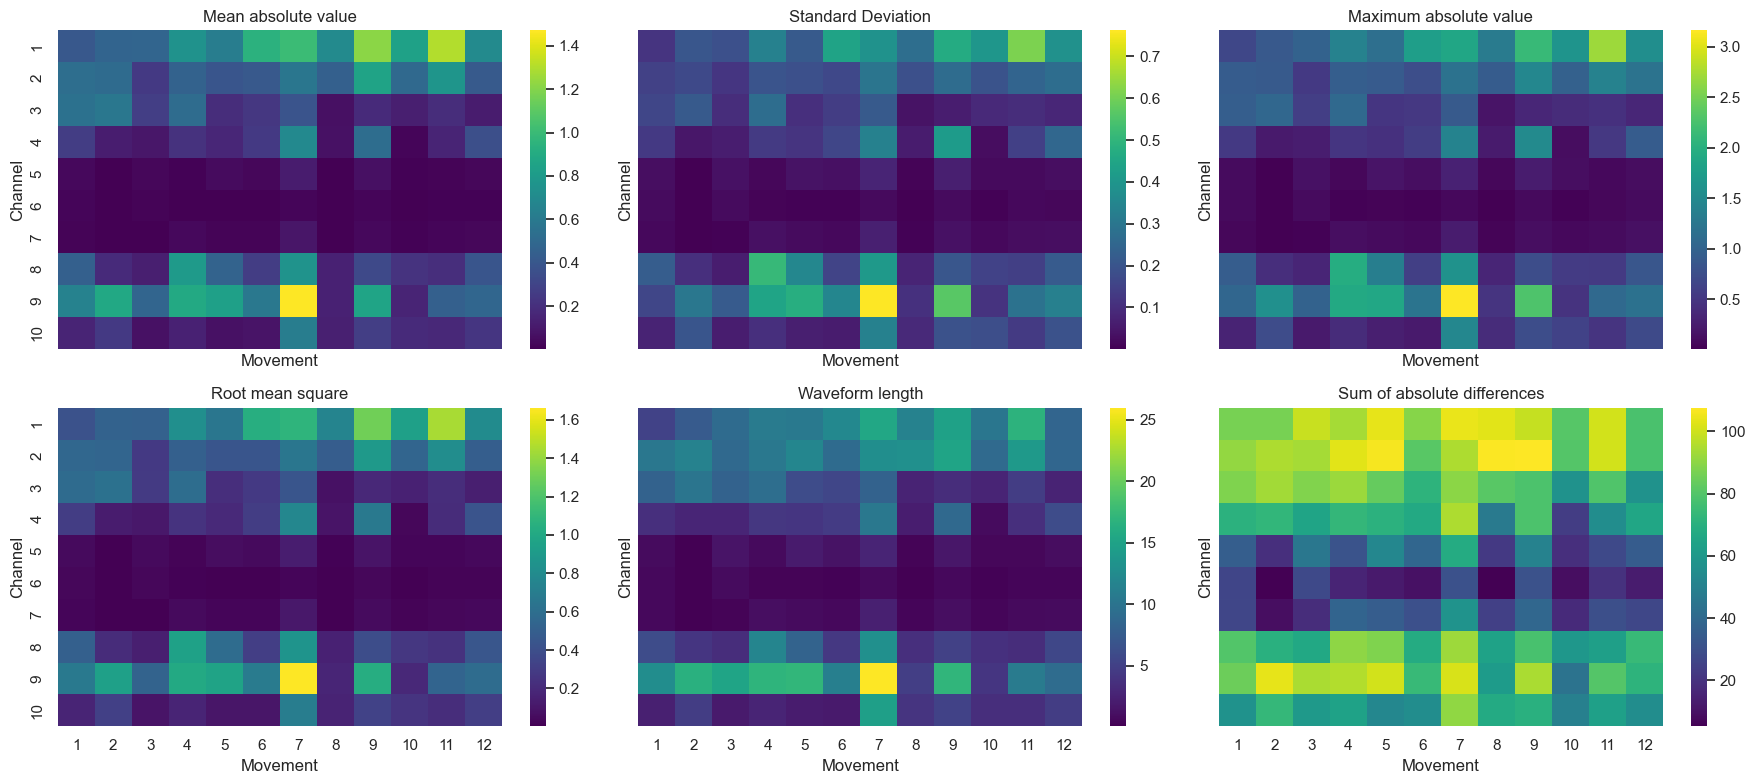

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.ravel()

for fi, ax in enumerate(axes):
    sns.heatmap(
        means[fi, :, :],          # shape (channels, movements)
        ax=ax,
        cmap="viridis",
        cbar=True
    )
    ax.set_title(feature_names[fi])

    ax.set_xlabel("Movement")
    ax.set_ylabel("Channel")

    ax.set_xticks(np.arange(n_movements) + 0.5)
    ax.set_xticklabels(unique_labels)

    ax.set_yticks(np.arange(n_channels) + 0.5)
    ax.set_yticklabels(np.arange(1, n_channels + 1))

plt.tight_layout()
plt.show()


## Data splitting into train set, test set and validation set

In [70]:
# 1) Train / temp split (temp will be split into val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    dataset,
    labels,
    test_size=0.4,          # 40% goes to val+test
    random_state=0,
    stratify=labels         # keep class proportions
)

# 2) Validation / test split (from the temp set)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,          # half of the 40% → 20% test, 20% val
    random_state=0,
    stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (72, 60), Val: (24, 60), Test: (24, 60)


## Model fitting

Validation accuracy: 0.708
Test accuracy: 0.625


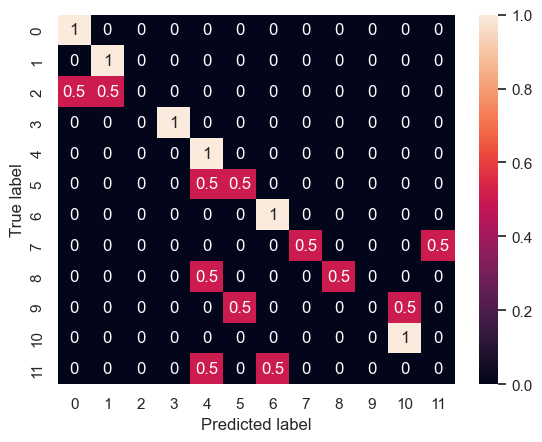

In [ ]:
# Normalizing the data 
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z   = scaler.transform(X_val)
X_test_z  = scaler.transform(X_test)


# Train a Gradient Boosting classifier on the normalized data
clf = GradientBoostingClassifier(
    n_estimators=100,      # number of trees
    learning_rate=0.1,    # step size
    max_depth=3,          # depth of individual trees
    random_state=0
)
clf.fit(X_train_z, y_train)

# 5) Evaluate on validation and test sets
y_val_pred = clf.predict(X_val_z)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.3f}")

y_test_pred = clf.predict(X_test_z)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_acc:.3f}")

# Confusion matrix on test set
confmat = confusion_matrix(y_test, y_test_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");


## Hyperparameter optimization

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import itertools

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.8],
}

# Generate all combinations
param_combinations = list(itertools.product(*param_grid.values()))

best_params = None
best_val_acc = -1

print(f"Total combinations: {len(param_combinations)}\n")

# Loop with tqdm progress bar
for params in tqdm(param_combinations, desc="Hyperparameter search"):
    
    # Convert tuple → dict
    params_dict = dict(zip(param_grid.keys(), params))

    # Train on training set
    model = GradientBoostingClassifier(
        random_state=42,
        **params_dict
    )
    model.fit(X_train_z, y_train)

    # Validate on validation set
    y_val_pred = model.predict(X_val_z)
    val_acc = accuracy_score(y_val, y_val_pred)

    # Track best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params_dict

# Print results
print("\nBest hyperparameters:", best_params)
print("Best validation accuracy:", best_val_acc)


Total combinations: 54



Hyperparameter search: 100%|██████████| 54/54 [05:02<00:00,  5.59s/it]


Best hyperparameters: {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.6}
Best validation accuracy: 0.9583333333333334


## Model evaluation

In [74]:
final_model = GradientBoostingClassifier(
    random_state=42,
    **best_params
)
final_model.fit(X_train_z, y_train)

y_test_pred = final_model.predict(X_test_z)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Final test accuracy: {test_acc:.4f}")


Final test accuracy: 0.8333
